# **Modelo #1: Análisis de Correlación para Entender la Relación Entre Precios de Insumos y Exportaciones**

**Objetivo:** Evaluar cómo los costos de insumos agrícolas (por ejemplo, fertilizantes o pesticidas importados) afectan las exportaciones de ciertos cultivos

**Metodología:** Modelos de Random Forest Regressor o Gradient Boosting Regressor, que sirven capturar interacciones y patrones más sofisticados entre los precios de los insumos y las exportaciones. Además la regresión lineal multiple con regularización, también podría darnos un resultado significativo en este caso.

Para empezar con este modelo debemos realizar un Feature Engineering primero de forma que podamos ver si existe una relación entre los precios de índices de insumos agrícolas y el valor de la exportación

In [51]:
#!pip install xgboost

In [38]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [2]:
insumos = pd.read_csv("_ndice_de_precios_de_insumos_agr_colas_20241104.csv")
exportaciones = pd.read_csv("exportaciones_2018_2024_agricultura.csv")

In [3]:
insumos.head()

,Fecha,Indice_total,Total_Fertilizantes,Total_Plaguicidas,Total_Otros,Total_Simples,Total_Compuestos,Total_Herbicidas,Total_Fungicidas,Total_Insecticidas,...,Metomil,Tiametoxam + lambdacihalotrina,Abamectina,Imidacloprid,Profenofos + cipermetrina,Cipermetrina,Profenofos,Total_Coadyuvantes,Total_Reguladores,Total_Molusquicidas
0,12/2018,90.67,90.36,91.24,NaN,91.57,89.41,93.56,90.30,87.04,...,82.84,93.01,90.97,92.52,80.13,85.94,83.91,0.0,0.0,0.0
1,01/2019,92.72,93.49,91.31,NaN,95.64,91.81,93.51,90.47,87.30,...,83.39,92.81,92.02,91.80,80.17,85.39,83.87,0.0,0.0,0.0
2,02/2019,94.06,95.59,91.29,NaN,98.04,93.68,93.34,90.64,87.43,...,82.97,92.90,92.77,92.15,80.44,87.05,83.71,0.0,0.0,0.0
3,03/2019,95.22,97.22,91.58,NaN,99.49,95.45,93.51,91.24,87.72,...,83.33,93.44,92.33,92.21,80.20,87.75,83.82,0.0,0.0,0.0
4,04/2019,95.34,97.27,91.85,NaN,99.19,95.77,93.62,91.63,88.23,...,84.57,93.58,92.27,92.93,81.78,89.43,84.19,0.0,0.0,0.0


In [4]:
tipo_cultivo = {
    "Cultivos tropicales tradicionales": ["cultivo", "siembra", "café"],
    "Frutales": ["fruta", "piñas", "aguacates", "bananas"],
    "Raíces y tubérculos": ["raíces", "tubérculos", 'Papa', 'Batata', 'Yuca', 'Ñame', 'Arrurruz', 'Mandioca', 'Camote', 'Oca', 'Taro', 'Raíz de loto',
                            'Apio nabo', 'Almidón de papa', 'Jícama', 'Rábano', 'Salsifí', 'Yam bean', 'Chufa', 'Rutabaga', 'Kale', 'Boniato'],
    "Cereales": ["cereales", "harina"],
    "Hortalizas": ["hortalizas", 'Zanahoria', 'Lechuga', 'Espinaca', 'Tomate', 'Pepino', 'Cebolla', 'Ajo', 'Pimiento', 'Berenjena', 'Brócoli', 'Coliflor',
                   'Apio', 'Guisante', 'Judía verde', 'Calabacín', 'Puerro', 'Rábano', 'Chícharo', 'Remolacha', 'Papas'],
    "Oleaginosas": ["oleaginosas", 'Soya', 'Almendra', 'Cacahuate', 'Nuez', 'Anacardo', 'Acelga', 'Girasol', 'Lino', 'Oliva', 'Sésamo', 'Castaña de cajú',
                    'Pistacho', 'Hemp', 'Nuez de macadamia', 'Chía', 'Acelga', 'Coco', 'Pecan', 'Cártamo'],
    "Leguminosas": ["legumbres", "vegetales", 'Frijol', 'Lenteja', 'Guisante', 'Garbanzos', 'Soja', 'Alfalfa', 'Cacahuate', 'Judía', 'Péverde', 'Chícharo',
                    'Almendra de palo', 'Frijol mungo', 'Frijol negro', 'Frijol pintón', 'Frijol rojo', 'Lupino', 'Habichuela', 'Pescado', 'Tamarindo', 'Frijol de soya'],
    "Cultivos para condimentos, bebidas medianas y aromáticas": ["bebida", "alcohol", "condimentos", "aromática", "especias"]
}


In [5]:
# Asignar la columna 'tipo_cultivo' directamente al DataFrame 'exportaciones'
exportaciones['tipo_cultivo'] = exportaciones['nombre_partida'].apply(
    lambda nombre_partida: next(
        (cultivo for cultivo, keywords in tipo_cultivo.items() 
         if any(keyword in str(nombre_partida).lower() for keyword in keywords)),
        "No asignado"
    )
)

# Mostrar el DataFrame resultante con la nueva columna 'tipo_cultivo'
exportaciones.drop(columns=["Unnamed: 0", "unnamed:_0", "departamento_origen", "pais_destino", "codigo_capitulo"])


,anio,mes,codigo_depto_origen,codigo_pais_destino,codigo_partida,nombre_partida,codigo_ciiu_rev4,descripcion_ciiu_rev4,nombre_capitulo,nivel_tecnologico,codigo_unidad,unidad,dolares_fob,kilogramos_netos,cantidad,tipo_cultivo
0,2018,1,5,17,803,"bananas_o_plátanos,_frescos_o_secos",NaN,cultivo_de_plátano_y_banano,"frutos_comestibles,_cortezas_de_agrios_o_melones",bienes_primarios,kg,kilogramo,72576.00,168480.0,168480.0,Frutales
1,2018,1,5,23,511,productos_de_origen_animal_no_expresados_ni_co...,NaN,procesamiento_y_conservación_de_carne_y_produc...,demás_productos_de_origen_animal,bienes_primarios,kg,kilogramo,14850.00,33000.0,33000.0,No asignado
2,2018,1,5,23,603,"flores_y_capullos,_cortados_para_ramos_o_adorn...",NaN,cultivo_de_flor_de_corte,plantas_vivas_y_productos_de_la_floricultura,bienes_primarios,u,unidades_o_artículos,1625.10,334.0,3060.0,No asignado
3,2018,1,5,23,803,"bananas_o_plátanos,_frescos_o_secos",NaN,cultivo_de_plátano_y_banano,"frutos_comestibles,_cortezas_de_agrios_o_melones",bienes_primarios,kg,kilogramo,4730443.55,13466579.0,13466579.0,Frutales
4,2018,1,5,23,804,"dátiles,_higos,_piñas_(ananás),__aguacates_(pa...",NaN,cultivo_de_frutas_tropicales_y_subtropicales,"frutos_comestibles,_cortezas_de_agrios_o_melones",bienes_primarios,kg,kilogramo,210805.38,109190.0,109190.0,Frutales
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255709,2024,8,76,880,1704,artículos_de_confitería_sin_cacao_(incluido_el...,1082.0,"elaboración_de_cacao,_chocolate_y_productos_de...",azúcares_y_artículos_confitería,manufacturas_basadas_en_recursos_naturales,kg,kilogramo,97248.92,70297.5,70297.5,No asignado
255710,2024,8,76,913,4415,"cajones,_cajas,_jaulas,_tambores_y_envases_sim...",1640.0,fabricación_de_recipientes_de_madera,"madera,_carbón_vegetal_y_manufacturas_de_madera",manufacturas_basadas_en_recursos_naturales,u,unidades_o_artículos,482.48,525.6,30.0,No asignado
255711,2024,8,76,917,4205,las_demás_manufacturas_de_cuero_natural_o_cuer...,1512.0,"fabricación_de_artículos_de_viaje,_bolsos_de_m...","manufacturas_de_cuero,_artículos_de_viaje,_bolsos",manufacturas_de_baja_tecnología,u,unidades_o_artículos,234.28,44.0,362.0,No asignado
255712,2024,8,81,27,402,"leche_y_nata_(crema),_concentradas_o_con_adici...",1040.0,elaboración_de_productos_lácteos,"leche_y_productos_lácteos,_huevos,_miel",bienes_primarios,kg,kilogramo,1072.08,610.0,610.0,No asignado


In [6]:
# Convertir la columna 'Fecha' de 'insumos' a formato datetime para extraer el año
insumos['anio'] = pd.to_datetime(insumos['Fecha'], format='%m/%Y').dt.year

# Calcular el promedio de 'Indice_total' por año en 'insumos'
insumos_promedio = insumos.groupby('anio')['Indice_total'].mean().reset_index()

# Merge para agregar el promedio de 'Indice_total' al DataFrame de exportaciones basado en el 'anio'
exportaciones = exportaciones.merge(insumos_promedio, on='anio', how='left')

# Eliminar columnas no deseadas
exportaciones.drop(columns=["Unnamed: 0", "unnamed: 0"], errors='ignore', inplace=True)

# Mostrar el resultado
exportaciones


,unnamed:_0,anio,mes,codigo_depto_origen,departamento_origen,codigo_pais_destino,pais_destino,codigo_partida,nombre_partida,codigo_ciiu_rev4,...,codigo_capitulo,nombre_capitulo,nivel_tecnologico,codigo_unidad,unidad,dolares_fob,kilogramos_netos,cantidad,tipo_cultivo,Indice_total
0,9,2018,1,5,antioquia,17,albania,803,"bananas_o_plátanos,_frescos_o_secos",NaN,...,8,"frutos_comestibles,_cortezas_de_agrios_o_melones",bienes_primarios,kg,kilogramo,72576.00,168480.0,168480.0,Frutales,90.670000
1,15,2018,1,5,antioquia,23,alemania,511,productos_de_origen_animal_no_expresados_ni_co...,NaN,...,5,demás_productos_de_origen_animal,bienes_primarios,kg,kilogramo,14850.00,33000.0,33000.0,No asignado,90.670000
2,16,2018,1,5,antioquia,23,alemania,603,"flores_y_capullos,_cortados_para_ramos_o_adorn...",NaN,...,6,plantas_vivas_y_productos_de_la_floricultura,bienes_primarios,u,unidades_o_artículos,1625.10,334.0,3060.0,No asignado,90.670000
3,17,2018,1,5,antioquia,23,alemania,803,"bananas_o_plátanos,_frescos_o_secos",NaN,...,8,"frutos_comestibles,_cortezas_de_agrios_o_melones",bienes_primarios,kg,kilogramo,4730443.55,13466579.0,13466579.0,Frutales,90.670000
4,18,2018,1,5,antioquia,23,alemania,804,"dátiles,_higos,_piñas_(ananás),__aguacates_(pa...",NaN,...,8,"frutos_comestibles,_cortezas_de_agrios_o_melones",bienes_primarios,kg,kilogramo,210805.38,109190.0,109190.0,Frutales,90.670000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255709,982609,2024,8,76,valle_del_cauca,880,yemen,1704,artículos_de_confitería_sin_cacao_(incluido_el...,1082.0,...,17,azúcares_y_artículos_confitería,manufacturas_basadas_en_recursos_naturales,kg,kilogramo,97248.92,70297.5,70297.5,No asignado,138.417778
255710,982613,2024,8,76,valle_del_cauca,913,sociedad_operadora_zona_franca_industrial_de_b...,4415,"cajones,_cajas,_jaulas,_tambores_y_envases_sim...",1640.0,...,44,"madera,_carbón_vegetal_y_manufacturas_de_madera",manufacturas_basadas_en_recursos_naturales,u,unidades_o_artículos,482.48,525.6,30.0,No asignado,138.417778
255711,982615,2024,8,76,valle_del_cauca,917,promotora_nacional_de_zona_francas_s.a._(zona_...,4205,las_demás_manufacturas_de_cuero_natural_o_cuer...,1512.0,...,42,"manufacturas_de_cuero,_artículos_de_viaje,_bolsos",manufacturas_de_baja_tecnología,u,unidades_o_artículos,234.28,44.0,362.0,No asignado,138.417778
255712,982620,2024,8,81,aráuca,27,aruba,402,"leche_y_nata_(crema),_concentradas_o_con_adici...",1040.0,...,4,"leche_y_productos_lácteos,_huevos,_miel",bienes_primarios,kg,kilogramo,1072.08,610.0,610.0,No asignado,138.417778


In [7]:
len(exportaciones.departamento_origen.unique())

33

In [8]:
max(exportaciones.codigo_pais_destino)

989

In [9]:
min(exportaciones.codigo_pais_destino)

13

In [109]:
df_full_train, df_test = train_test_split(exportaciones, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.dolares_fob.values)
y_val = np.log1p(df_val.dolares_fob.values)
y_test = np.log1p(df_test.dolares_fob.values)

del df_train['dolares_fob']
del df_val['dolares_fob']
del df_test['dolares_fob']

In [110]:
df_full_train = df_full_train.reset_index(drop=True)

In [111]:
len(df_train), len(df_val), len(df_test)

(153428, 51143, 51143)

In [112]:
def asignar_grupos_por_frecuencia(df):
    pais_frecuencia = df['pais_destino'].value_counts()

    bins = [1, 2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000, 20000, 22000, 25000]
    labels = range(1, len(bins))

    pais_group = {}

    for pais, count in pais_frecuencia.items():
        for i in range(len(bins)-1):
            if bins[i] <= count < bins[i+1]:
                pais_group[pais] = i + 1  # Asignar el grupo (1, 2, ..., 10)
                break

    df['pais_destino_group'] = df['pais_destino'].map(pais_group)

    return df

df_train = asignar_grupos_por_frecuencia(df_train)
df_val = asignar_grupos_por_frecuencia(df_val)
df_test = asignar_grupos_por_frecuencia(df_test)

In [113]:
df_train

,unnamed:_0,anio,mes,codigo_depto_origen,departamento_origen,codigo_pais_destino,pais_destino,codigo_partida,nombre_partida,codigo_ciiu_rev4,...,codigo_capitulo,nombre_capitulo,nivel_tecnologico,codigo_unidad,unidad,kilogramos_netos,cantidad,tipo_cultivo,Indice_total,pais_destino_group
0,463787,2021,4,66,risaralda,239,ecuador,1701,azúcar_de_caña_o_de_remolacha_y_sacarosa_quími...,1071.0,...,17,azúcares_y_artículos_confitería,manufacturas_basadas_en_recursos_naturales,kg,kilogramo,875990.00,875990.00,No asignado,123.621667,6
1,344306,2020,6,73,tolima,239,ecuador,407,"huevos_de_ave_con_cáscara_(cascarón),_frescos,...",145.0,...,4,"leche_y_productos_lácteos,_huevos,_miel",bienes_primarios,u,unidades_o_artículos,2880.00,57600.00,No asignado,99.295000,6
2,780694,2023,6,5,antioquia,242,el_salvador,4202,"baúles,_maletas_(valijas),_maletines,_incluido...",1512.0,...,42,"manufacturas_de_cuero,_artículos_de_viaje,_bolsos",manufacturas_de_baja_tecnología,u,unidades_o_artículos,283.82,636.00,"Cultivos para condimentos, bebidas medianas y ...",180.758333,2
3,737446,2023,2,68,santander,249,estados_unidos,4407,madera_aserrada_o_desbastada_longitudinalmente...,1610.0,...,44,"madera,_carbón_vegetal_y_manufacturas_de_madera",manufacturas_basadas_en_recursos_naturales,m3,metro_cúbico,7495.00,35280.00,No asignado,180.758333,8
4,349289,2020,7,11,bogotá,69,australia,1704,artículos_de_confitería_sin_cacao_(incluido_el...,1082.0,...,17,azúcares_y_artículos_confitería,manufacturas_basadas_en_recursos_naturales,kg,kilogramo,120.12,120.12,No asignado,99.295000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153423,173289,2019,3,68,santander,200,curazao,807,"melones,_sandías_y_papayas,_frescos",121.0,...,8,"frutos_comestibles,_cortezas_de_agrios_o_melones",bienes_primarios,kg,kilogramo,5640.00,5640.00,No asignado,95.619167,4
153424,484797,2021,6,25,cundinamarca,211,chile,603,"flores_y_capullos,_cortados_para_ramos_o_adorn...",125.0,...,6,plantas_vivas_y_productos_de_la_floricultura,bienes_primarios,u,unidades_o_artículos,10594.00,262573.00,No asignado,123.621667,3
153425,428530,2021,1,76,valle_del_cauca,589,perú,1701,azúcar_de_caña_o_de_remolacha_y_sacarosa_quími...,1071.0,...,17,azúcares_y_artículos_confitería,manufacturas_basadas_en_recursos_naturales,kg,kilogramo,6871850.00,6871850.00,No asignado,123.621667,4
153426,503654,2021,8,5,antioquia,580,panamá,2101,"extractos,_esencias_y_concentrados_de_café,_té...",1063.0,...,21,preparaciones_alimenticias_diversas,bienes_primarios,kg,kilogramo,5701.74,5701.74,Cultivos tropicales tradicionales,123.621667,4


In [114]:
label_encoder = LabelEncoder()
df_train['tipo_cultivo_encoded'] = label_encoder.fit_transform(df_train['tipo_cultivo'])
df_val['tipo_cultivo_encoded'] = label_encoder.fit_transform(df_val['tipo_cultivo'])
df_test['tipo_cultivo_encoded'] = label_encoder.fit_transform(df_test['tipo_cultivo'])

In [115]:
df_train.columns

Index(['unnamed:_0', 'anio', 'mes', 'codigo_depto_origen',
       'departamento_origen', 'codigo_pais_destino', 'pais_destino',
       'codigo_partida', 'nombre_partida', 'codigo_ciiu_rev4',
       'descripcion_ciiu_rev4', 'codigo_capitulo', 'nombre_capitulo',
       'nivel_tecnologico', 'codigo_unidad', 'unidad', 'kilogramos_netos',
       'cantidad', 'tipo_cultivo', 'Indice_total', 'pais_destino_group',
       'tipo_cultivo_encoded'],
      dtype='object')

In [116]:
def aplicar_one_hot_encoding(df, columns_to_encode):
    encoder = OneHotEncoder(sparse_output=False)
    encoded_data = encoder.fit_transform(df[columns_to_encode])
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_encode))
    
    df_encoded = df.drop(columns=columns_to_encode).join(encoded_df)
    
    return df_encoded

columns_to_encode = ['pais_destino_group', "tipo_cultivo_encoded"]
df_train = aplicar_one_hot_encoding(df_train, columns_to_encode)
df_val = aplicar_one_hot_encoding(df_val, columns_to_encode)
df_test = aplicar_one_hot_encoding(df_test, columns_to_encode)

In [117]:
df_test.columns

Index(['unnamed:_0', 'anio', 'mes', 'codigo_depto_origen',
       'departamento_origen', 'codigo_pais_destino', 'pais_destino',
       'codigo_partida', 'nombre_partida', 'codigo_ciiu_rev4',
       'descripcion_ciiu_rev4', 'codigo_capitulo', 'nombre_capitulo',
       'nivel_tecnologico', 'codigo_unidad', 'unidad', 'kilogramos_netos',
       'cantidad', 'tipo_cultivo', 'Indice_total', 'pais_destino_group_1',
       'pais_destino_group_2', 'pais_destino_group_3',
       'tipo_cultivo_encoded_0', 'tipo_cultivo_encoded_1',
       'tipo_cultivo_encoded_2', 'tipo_cultivo_encoded_3',
       'tipo_cultivo_encoded_4', 'tipo_cultivo_encoded_5',
       'tipo_cultivo_encoded_6', 'tipo_cultivo_encoded_7'],
      dtype='object')

In [130]:
# columnas para el modelo

columns_selected = ["Indice_total", "cantidad", "kilogramos_netos", 'pais_destino_group_1',
       'pais_destino_group_2', 'pais_destino_group_3',
       'tipo_cultivo_encoded_0', 'tipo_cultivo_encoded_1',
       'tipo_cultivo_encoded_2', 'tipo_cultivo_encoded_3',
       'tipo_cultivo_encoded_4', 'tipo_cultivo_encoded_5',
       'tipo_cultivo_encoded_6', 'tipo_cultivo_encoded_7', "anio", "mes"]

In [131]:
df_train.columns

Index(['unnamed:_0', 'anio', 'mes', 'codigo_depto_origen',
       'departamento_origen', 'codigo_pais_destino', 'pais_destino',
       'codigo_partida', 'nombre_partida', 'codigo_ciiu_rev4',
       'descripcion_ciiu_rev4', 'codigo_capitulo', 'nombre_capitulo',
       'nivel_tecnologico', 'codigo_unidad', 'unidad', 'kilogramos_netos',
       'cantidad', 'tipo_cultivo', 'Indice_total', 'pais_destino_group_1',
       'pais_destino_group_2', 'pais_destino_group_3', 'pais_destino_group_4',
       'pais_destino_group_6', 'pais_destino_group_8',
       'tipo_cultivo_encoded_0', 'tipo_cultivo_encoded_1',
       'tipo_cultivo_encoded_2', 'tipo_cultivo_encoded_3',
       'tipo_cultivo_encoded_4', 'tipo_cultivo_encoded_5',
       'tipo_cultivo_encoded_6', 'tipo_cultivo_encoded_7'],
      dtype='object')

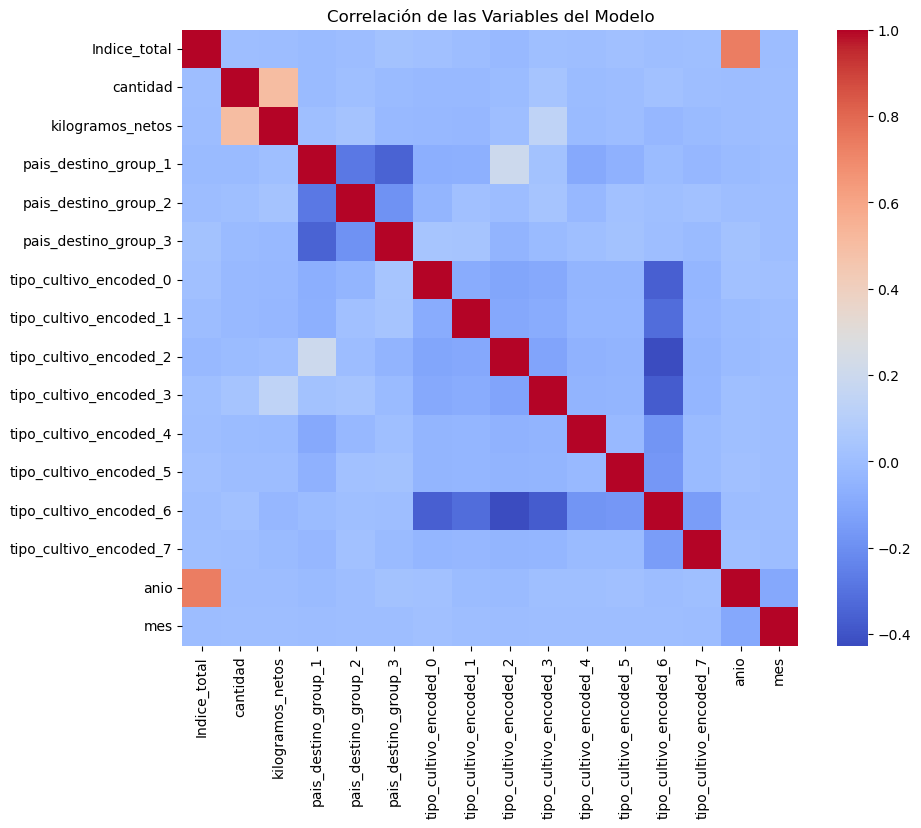

In [132]:
df_selected = df_train[columns_selected]
corr_matrix = df_selected.corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', square=True)
plt.title('Correlación de las Variables del Modelo')
plt.show()

In [133]:
X_train = df_train[columns_selected]
X_val = df_val[columns_selected]
X_test = df_test[columns_selected]

In [134]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso

In [135]:
print("**********Scores y resultados para Regularización de Ridge**********")
ridge = Ridge(alpha=10).fit(X_train, y_train) # mejor alpha escogido en la parte de abajo
print("Training set score: {:.2f}".format(ridge.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test, y_test)))
print("Validation set score: {:.2f}".format(ridge.score(X_val, y_val)))

# la prediccionn
y_pred_ridge_ = ridge.predict(X_train)

**********Scores y resultados para Regularización de Ridge**********
Training set score: 0.17
Test set score: 0.16
Validation set score: 0.16


/home/eli_gran/anaconda3/envs/gitdocs/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.56768e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [136]:
# Realizando Hyperparameter Tunning
hyperParameters = {'alpha': np.logspace(-15, 5, num=21)}
ridgeRegressor = GridSearchCV(ridge, hyperParameters, scoring='neg_mean_squared_error', cv=10)
ridgeRegressor.fit(X_train,y_train)

/home/eli_gran/anaconda3/envs/gitdocs/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.27253e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/eli_gran/anaconda3/envs/gitdocs/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.03374e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/eli_gran/anaconda3/envs/gitdocs/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.62539e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/eli_gran/anaconda3/envs/gitdocs/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.98209e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", over

GridSearchCV(cv=10, estimator=Ridge(alpha=10),
             param_grid={'alpha': array([1.e-15, 1.e-14, 1.e-13, 1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08,
       1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00,
       1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])},
             scoring='neg_mean_squared_error')

In [138]:
# ********** Random Forest **********
print("**********Scores y resultados para Random Forest**********")
rf = RandomForestRegressor(n_estimators=100, random_state=42)  # Puedes ajustar los hiperparámetros
rf.fit(X_train, y_train)

print("Training set score: {:.2f}".format(rf.score(X_train, y_train)))
print("Test set score: {:.2f}".format(rf.score(X_test, y_test)))
print("Validation set score: {:.2f}".format(rf.score(X_val, y_val)))

# Predicción de Random Forest sobre el conjunto de prueba
y_pred_rf = rf.predict(X_test)

# ********** AdaBoost **********
print("\n**********Scores y resultados para AdaBoost**********")
ab = AdaBoostRegressor(n_estimators=100, random_state=42)  # Puedes ajustar los hiperparámetros
ab.fit(X_train, y_train)

print("Training set score: {:.2f}".format(ab.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ab.score(X_test, y_test)))
print("Validation set score: {:.2f}".format(ab.score(X_val, y_val)))

# Predicción de AdaBoost sobre el conjunto de prueba
y_pred_ab = ab.predict(X_test)

# Evaluar en el conjunto de prueba (MSE)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mse_ab = mean_squared_error(y_test, y_pred_ab)

print(f"\nMSE para Random Forest en el conjunto de prueba: {mse_rf:.4f}")
print(f"MSE para AdaBoost en el conjunto de prueba: {mse_ab:.4f}")


**********Scores y resultados para Random Forest**********
Training set score: 0.98
Test set score: 0.83
Validation set score: 0.83

**********Scores y resultados para AdaBoost**********
Training set score: 0.78
Test set score: 0.74
Validation set score: 0.74

MSE para Random Forest en el conjunto de prueba: 1.2835
MSE para AdaBoost en el conjunto de prueba: 1.9136
